In [1]:
import sys
import os
from pathlib import Path
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

os.chdir('..')

from utils.meta_util import load_meta_infos, collect_by, filter_by
from utils.tensor_holders import TensorHolder
from utils.plot_util import plot, legend
from utils.np_util import step_with_end

plot_dir = Path('results')
losses_label = '$mc_estimator$ $sample_size$ sample(s)'

mnist_results = load_meta_infos(Path('results', 'vae', 'mnist'))

# Plot VAE MNIST Test Losses

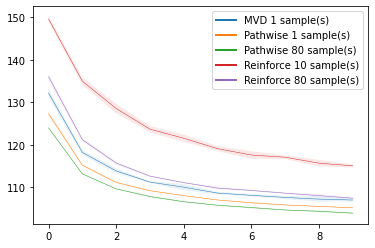

In [2]:
test_losses = defaultdict(list)
for k, v in collect_by(mnist_results, 'mc_estimator', 'sample_size').items():
    for meta in v:
        test_losses[k].append((meta, TensorHolder.load(meta['results_dir'], 'test_loss')))
test_losses.default_factory = None

for run in test_losses.values():
    meta, _ = run[0]
    losses = []
    for meta, loss in run:
        losses.append(loss.data.numpy().flatten())
    losses = np.array(losses)
    plot(losses.mean(axis=0), losses.std(axis=0), losses_label, meta)

legend()
plt.savefig(plot_dir / f'vae_test_losses.pdf')
plt.show()

# Plot VAE MNIST Train Losses

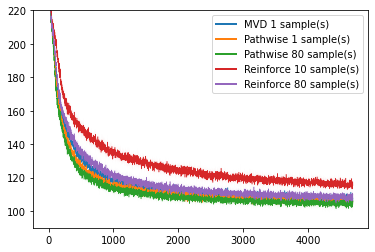

In [3]:
test_losses = defaultdict(list)
for k, v in collect_by(mnist_results, 'mc_estimator', 'sample_size').items():
    for meta in v:
        test_losses[k].append((meta, TensorHolder.load(meta['results_dir'], 'train_loss')))
test_losses.default_factory = None

for run in test_losses.values():
    meta, _ = run[0]
    losses = []
    for meta, loss in run:
        losses.append(loss.data.numpy().flatten())
    losses = np.array(losses)
    plot(losses.mean(axis=0), losses.std(axis=0), losses_label, meta)

legend()
plt.ylim(90, 220)
plt.savefig(plot_dir / f'vae_train_losses.pdf')
plt.show()

# Plot VAE MNIST Train Losses by process time

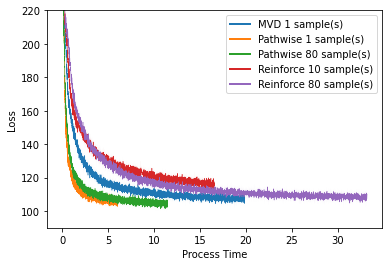

In [4]:
test_losses = defaultdict(list)
for k, v in collect_by(mnist_results, 'mc_estimator', 'sample_size').items():
    for meta in v:
        test_losses[k].append((meta, TensorHolder.load(meta['results_dir'], 'train_loss'), TensorHolder.load(meta['results_dir'], 'iteration_times')))
test_losses.default_factory = None

shortest_run = float('inf')
for run in test_losses.values():
    meta = run[0][0]
    losses = []
    timestamps = []
    for meta, loss, timestamp in run:
        losses.append(loss.data.numpy().flatten())
        timestamps.append(timestamp.data.numpy().flatten())
    losses = np.array(losses)
    timestamps = np.array(timestamps)
    timestamps = timestamps.mean(axis=0)
    shortest_run = min(shortest_run, timestamps[-1])
    plot(losses.mean(axis=0), losses.std(axis=0), losses_label, meta, xspace=timestamps)

legend()
plt.xlabel('Process Time')
plt.ylabel('Loss')
plt.ylim(90, 220)
plt.savefig(plot_dir / f'vae_train_timed_losses_until_end.pdf')
plt.show()

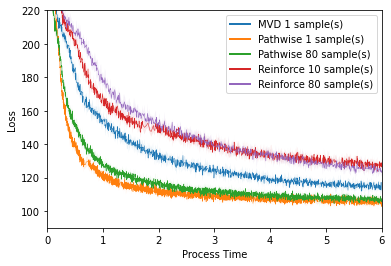

In [5]:
test_losses = defaultdict(list)
for k, v in collect_by(mnist_results, 'mc_estimator', 'sample_size').items():
    for meta in v:
        test_losses[k].append((meta, TensorHolder.load(meta['results_dir'], 'train_loss'), TensorHolder.load(meta['results_dir'], 'iteration_times')))
test_losses.default_factory = None

shortest_run = float('inf')
for run in test_losses.values():
    meta = run[0][0]
    losses = []
    timestamps = []
    for meta, loss, timestamp in run:
        losses.append(loss.data.numpy().flatten())
        timestamps.append(timestamp.data.numpy().flatten())
    losses = np.array(losses)
    timestamps = np.array(timestamps)
    timestamps = timestamps.mean(axis=0)
    shortest_run = min(shortest_run, timestamps[-1])
    plot(losses.mean(axis=0), losses.std(axis=0), losses_label, meta, xspace=timestamps)

legend()
plt.xlabel('Process Time')
plt.ylabel('Loss')
plt.ylim(90, 220)
if shortest_run < float('inf'):
    plt.xlim(0, shortest_run)
plt.savefig(plot_dir / f'vae_train_timed_losses.pdf')
plt.show()

# Convex combination of MV and SF estimators

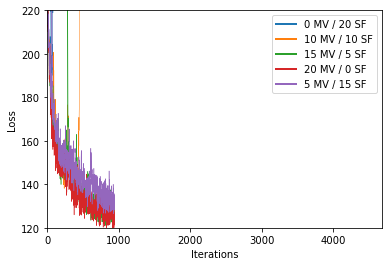

In [14]:
convex_results = load_meta_infos(Path('results', 'vae', 'mnist_mvsf'))

test_losses = defaultdict(list)
for k, v in collect_by(convex_results, 'mv_dims').items():
    for meta in v:
        test_losses[k].append((meta, TensorHolder.load(meta['results_dir'], 'train_loss')))
test_losses.default_factory = None

max_len = 0
step_size = 5
for run in test_losses.values():
    meta = run[0][0]
    losses = []
    for meta, loss in run:
        losses.append(loss.data.numpy().flatten())
    indices, losses = step_with_end(np.array(losses), step_size)
    mv_dims = meta['mv_dims']
    label = f'{mv_dims} MV / {20-mv_dims} SF'
    plot(losses.mean(axis=0), losses.std(axis=0), label, meta)
    max_len = max(max_len, indices[-1])

legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.ylim(120, 220)
plt.xlim(0, max_len-1)
plt.savefig(plot_dir / f'vae_mvsf_train_losses.pdf')
plt.show()